In [1]:
# general purpose python
import collections
import datetime
import glob
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('pytorch device:    ', device)

# geospatial
import rasterio as rio
import rasterio.features

ignore_warnings = True
if ignore_warnings:
    warnings.filterwarnings('ignore')
print('ignore warnings:   ', ignore_warnings)

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
print('random seed:       ', seed)

mpl.rcParams['figure.dpi'] = 200

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

_ = torch.autograd.set_detect_anomaly(False)

pytorch device:     cuda
ignore warnings:    True
random seed:        1337


### Load the data

In [2]:
def get_data_loader(image_size, batch_size):
    img_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.CenterCrop(image_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                         (0.5, 0.5, 0.5))])
    celeb_dataset = torchvision.datasets.ImageFolder(root='../data/celeba/',
                                                     transform=img_transform)
    data_loader = torch.utils.data.DataLoader(dataset=celeb_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4,
                                              pin_memory=True)
    return data_loader

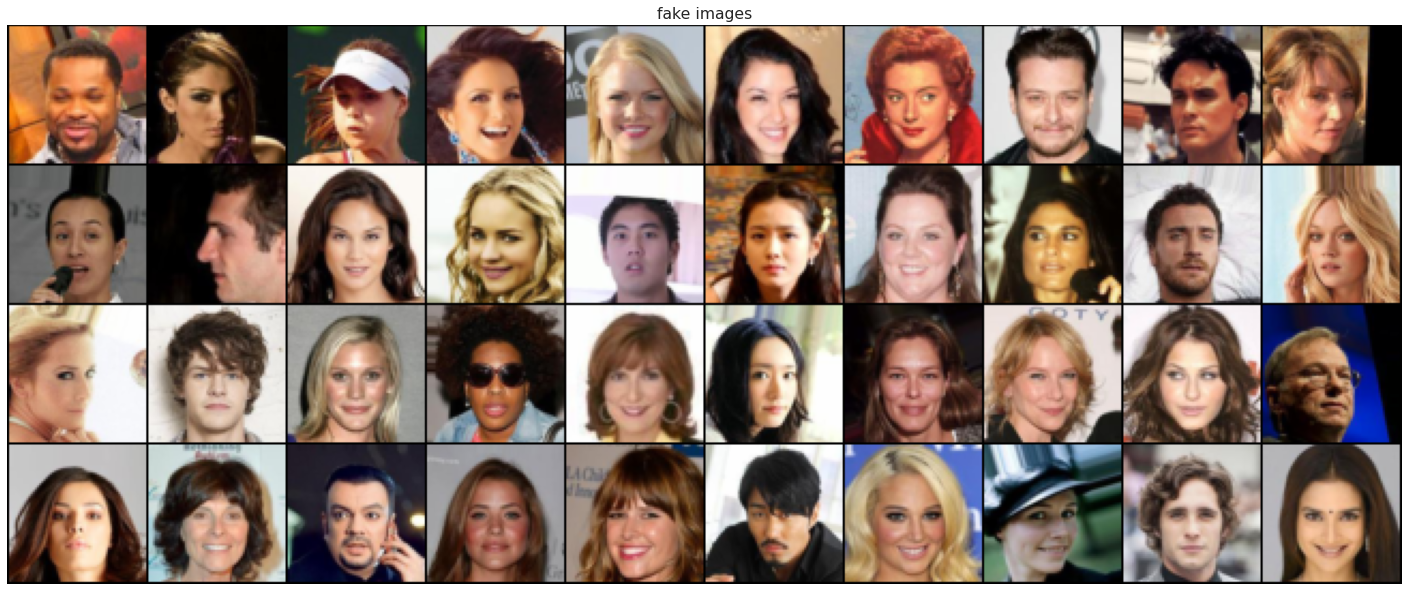

In [3]:
# take a look at some samples
data_loader = get_data_loader(2**6, 2**8)
batch = next(iter(data_loader))
plt.figure(figsize=(25,25))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0][:40],
                                                    nrow=10,
                                                    padding=1,
                                                    normalize=True).cpu(),(1,2,0)))
plt.axis('off')
plt.title(f'fake images')
plt.show()

### Define the model

In [4]:
# init model weights according to some papers
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# reshape node to unflatten input going from a dense layer to a conv transpose layer
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


# add noise to the layers inside the decoder that has zero mean and a variable std
class AddNoise(nn.Module):
    def __init__(self, layer_noise_std_multiplier):
        super(AddNoise, self).__init__()
        self.layer_noise_std_multiplier = layer_noise_std_multiplier

    def forward(self, x):
        return x + torch.randn(x.shape, device=torch.device('cuda')) * torch.std(x) * self.layer_noise_std_multiplier


class AutoEncoder(nn.Module):
    def __init__(self,
                 n_code_dim=32,
                 n_channels=3,
                 relu_slope=0.01,
                 bias=False,
                 n_encoder_feature_maps=16,
                 encoder_feature_map_multiplier=1,
                 n_encoder_dense_layers=0,
                 encoder_dense_neurons_multiplier=2,
                 encoder_dropout=0.0,
                 input_noise_p=0.0,
                 input_noise_std=0.0,
                 n_decoder_feature_maps=16,
                 decoder_feature_map_multiplier=1,
                 n_decoder_dense_layers=0,
                 decoder_dense_neurons_multiplier=2,
                 decoder_dropout=0.0,
                 layer_noise_std_multiplier=0.0):
        super(AutoEncoder, self).__init__()
        
        self.n_code_dim = n_code_dim
        self.n_channels = n_channels
        self.relu_slope = relu_slope
        self.bias = bias
        self.n_encoder_feature_maps = n_encoder_feature_maps
        self.encoder_feature_map_multiplier = encoder_feature_map_multiplier
        self.n_encoder_dense_layers = n_encoder_dense_layers
        self.encoder_dense_neurons_multiplier = encoder_dense_neurons_multiplier
        self.encoder_dropout = encoder_dropout
        self.input_noise_p = input_noise_p
        self.input_noise_std = input_noise_std
        self.n_decoder_feature_maps = n_decoder_feature_maps
        self.decoder_feature_map_multiplier = decoder_feature_map_multiplier
        self.n_decoder_dense_layers = n_decoder_dense_layers
        self.decoder_dense_neurons_multiplier = decoder_dense_neurons_multiplier
        self.decoder_dropout = decoder_dropout
        self.layer_noise_std_multiplier = layer_noise_std_multiplier
        
        encoder_modules = [
            torch.jit.script(AddNoise(layer_noise_std_multiplier=self.input_noise_std)),
            nn.Conv2d(in_channels=self.n_channels,
                      out_channels=self.n_encoder_feature_maps,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=self.n_encoder_feature_maps),
            nn.Dropout(self.encoder_dropout),
            nn.LeakyReLU(negative_slope=self.relu_slope,
                         inplace=True)]
        
        n_fm = self.n_encoder_feature_maps
        for i in range(3):
            encoder_modules.append(nn.Conv2d(in_channels=n_fm,
                                             out_channels=n_fm * self.encoder_feature_map_multiplier,
                                             kernel_size=4,
                                             stride=2,
                                             padding=1,
                                             bias=False))
            encoder_modules.append(nn.BatchNorm2d(num_features=n_fm * self.encoder_feature_map_multiplier))
            if encoder_dropout > 0:
                encoder_modules.append(nn.Dropout(self.encoder_dropout))
            encoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))
            n_fm *= self.encoder_feature_map_multiplier

        encoder_modules.append(nn.Conv2d(in_channels=n_fm,
                                         out_channels=n_code_dim if self.n_encoder_dense_layers == 0 else self.n_code_dim * self.encoder_dense_neurons_multiplier,
                                         kernel_size=4,
                                         stride=1,
                                         padding=0,
                                         bias=False))
        encoder_modules.append(nn.BatchNorm2d(num_features=n_code_dim if self.n_encoder_dense_layers == 0 else self.n_code_dim * self.encoder_dense_neurons_multiplier))
        
        encoder_modules.append(nn.Flatten())
        
        if self.n_encoder_dense_layers > 0:
            for i in range(self.n_encoder_dense_layers - 1):
                if encoder_dropout > 0:
                    encoder_modules.append(nn.Dropout(self.encoder_dropout))
                encoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))
                encoder_modules.append(nn.Linear(in_features=self.n_code_dim * self.encoder_dense_neurons_multiplier,
                                                 out_features=self.n_code_dim * self.encoder_dense_neurons_multiplier,
                                                 bias=self.bias))
            
            if encoder_dropout > 0:
                encoder_modules.append(nn.Dropout(self.encoder_dropout))
            encoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))
            encoder_modules.append(nn.Linear(in_features=self.n_code_dim * self.encoder_dense_neurons_multiplier,
                                             out_features=self.n_code_dim,
                                             bias=self.bias))
        
        if encoder_dropout > 0:
                encoder_modules.append(nn.Dropout(self.encoder_dropout))
        encoder_modules.append(nn.Sigmoid())
        
        encoder_modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(encoder_modules))], encoder_modules))
        self.encoder = nn.Sequential(encoder_modules)
        weights_init(self.encoder)
        
        decoder_modules = []
        if n_decoder_dense_layers > 0:
            decoder_modules.append(nn.Linear(in_features=self.n_code_dim,
                                             out_features=self.n_code_dim * self.decoder_dense_neurons_multiplier,
                                             bias=self.bias))
            decoder_modules.append(torch.jit.script(AddNoise(self.layer_noise_std_multiplier)))
            if decoder_dropout > 0:
                decoder_modules.append(nn.Dropout(self.decoder_dropout))
            decoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))
            
            for i in range(self.n_decoder_dense_layers - 1):
                decoder_modules.append(nn.Linear(in_features=self.n_code_dim * self.decoder_dense_neurons_multiplier,
                                                 out_features=self.n_code_dim * self.decoder_dense_neurons_multiplier,
                                                 bias=self.bias))
                decoder_modules.append(torch.jit.script(AddNoise(self.layer_noise_std_multiplier)))
                if decoder_dropout > 0:
                    decoder_modules.append(nn.Dropout(self.decoder_dropout))
                decoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))

        decoder_modules.append(Reshape(-1, self.n_code_dim if self.n_decoder_dense_layers == 0 else self.n_code_dim * self.decoder_dense_neurons_multiplier, 1, 1))
        
        n_fm = self.n_decoder_feature_maps * self.decoder_feature_map_multiplier**3
        decoder_modules.append(nn.ConvTranspose2d(in_channels=self.n_code_dim if self.n_decoder_dense_layers == 0 else self.n_code_dim * self.decoder_dense_neurons_multiplier,
                                                  out_channels=n_fm,
                                                  kernel_size=4,
                                                  stride=1,
                                                  padding=0,
                                                  bias=False))
        decoder_modules.append(torch.jit.script(AddNoise(self.layer_noise_std_multiplier)))
        decoder_modules.append(nn.BatchNorm2d(num_features=n_fm))
        if decoder_dropout > 0:
                decoder_modules.append(nn.Dropout(self.decoder_dropout))
        decoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                            inplace=True))
        
        for i in range(3):
            n_fm = int(n_fm / self.decoder_feature_map_multiplier)
            decoder_modules.append(nn.ConvTranspose2d(in_channels=n_fm * self.decoder_feature_map_multiplier,
                                                      out_channels=n_fm,
                                                      kernel_size=4,
                                                      stride=2,
                                                      padding=1,
                                                      bias=self.bias))
            decoder_modules.append(nn.BatchNorm2d(num_features=n_fm))
            if decoder_dropout > 0:
                decoder_modules.append(nn.Dropout(self.decoder_dropout))
            decoder_modules.append(nn.LeakyReLU(negative_slope=self.relu_slope,
                                                inplace=True))

        decoder_modules.append(nn.ConvTranspose2d(in_channels=n_fm,
                                              out_channels=self.n_channels,
                                              kernel_size=4,
                                              stride=2,
                                              padding=1,
                                              bias=False))
        decoder_modules.append(nn.BatchNorm2d(num_features=self.n_channels))
        if decoder_dropout > 0:
                decoder_modules.append(nn.Dropout(self.decoder_dropout))
        
        decoder_modules.append(nn.Tanh())
        
        decoder_modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(decoder_modules))], decoder_modules))
        self.decoder = nn.Sequential(decoder_modules)
        weights_init(self.decoder)

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
    
    def get_hyperparams(self):
        hyperparams = collections.OrderedDict()
        hyperparams['n_code_dim'] = self.n_code_dim
        hyperparams['n_channels'] = self.n_channels
        hyperparams['relu_slope'] = self.relu_slope
        hyperparams['bias'] = self.bias
        hyperparams['n_encoder_feature_maps'] = self.n_encoder_feature_maps
        hyperparams['encoder_feature_map_multiplier'] = self.encoder_feature_map_multiplier
        hyperparams['n_encoder_dense_layers'] = self.n_encoder_dense_layers
        hyperparams['encoder_dense_neurons_multiplier'] = self.encoder_dense_neurons_multiplier
        hyperparams['encoder_dropout'] = self.encoder_dropout
        hyperparams['input_noise_p'] = self.input_noise_p
        hyperparams['input_noise_std'] = self.input_noise_std
        hyperparams['n_decoder_feature_maps'] = self.n_decoder_feature_maps
        hyperparams['decoder_feature_map_multiplier'] = self.decoder_feature_map_multiplier
        hyperparams['n_decoder_dense_layers'] = self.n_decoder_dense_layers
        hyperparams['decoder_dense_neurons_multiplier'] = self.decoder_dense_neurons_multiplier
        hyperparams['decoder_dropout'] = self.decoder_dropout
        hyperparams['layer_noise_std_multiplier'] = self.layer_noise_std_multiplier
        return hyperparams


# create an instance
ae = AutoEncoder(n_decoder_dense_layers=2,
                 n_encoder_dense_layers=2).to(device)
print(ae)
print(ae.get_hyperparams())

# make sure that the input/output sizes are correct
x = torch.rand(128 * 3 * 64 * 64).view(128, 3, 64, 64).to(device)
print('input shape:  ', x.shape)
y = ae.forward(x)
print('output shape: ', y.shape)
print(y.dtype)

AutoEncoder(
  (encoder): Sequential(
    (layer_000): RecursiveScriptModule(original_name=AddNoise)
    (layer_001): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (layer_002): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_003): Dropout(p=0.0, inplace=False)
    (layer_004): LeakyReLU(negative_slope=0.01, inplace=True)
    (layer_005): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (layer_006): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_007): LeakyReLU(negative_slope=0.01, inplace=True)
    (layer_008): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (layer_009): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_010): LeakyReLU(negative_slope=0.01, inplace=True)
    (layer_011): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

time: 10:23:41        epoch: 001/005        batch: 00791/00792        loss: 0.1056        
time: 10:24:37        epoch: 002/005        batch: 00791/00792        loss: 0.0994        
time: 10:25:35        epoch: 003/005        batch: 00791/00792        loss: 0.1005        
time: 10:26:34        epoch: 004/005        batch: 00791/00792        loss: 0.0934        
time: 10:27:33        epoch: 005/005        batch: 00791/00792        loss: 0.0909        
n_code_dim                               8
n_channels                               3
relu_slope                               0.01
bias                                     False
n_encoder_feature_maps                   32
encoder_feature_map_multiplier           2
n_encoder_dense_layers                   0
encoder_dense_neurons_multiplier         4
encoder_dropout                          0.0
input_noise_p                            0.0
input_noise_std                          0.0
n_decoder_feature_maps                   32
decoder_featur

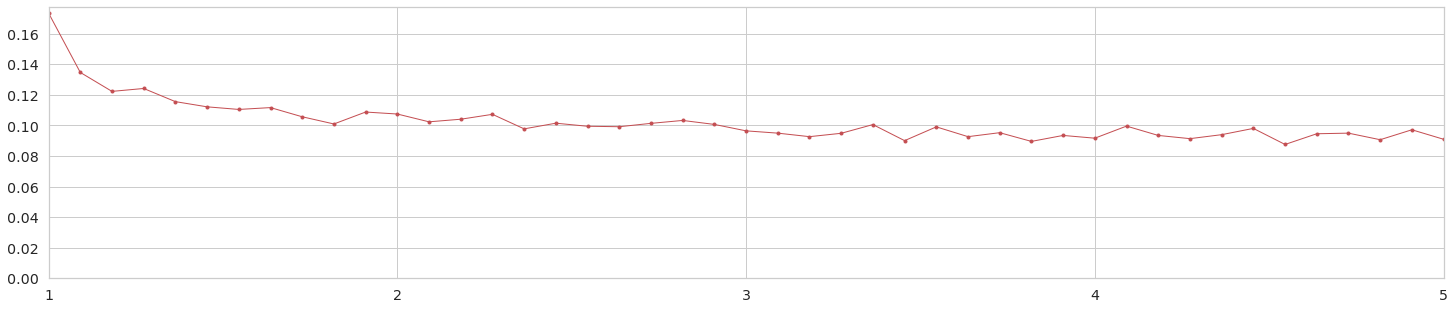

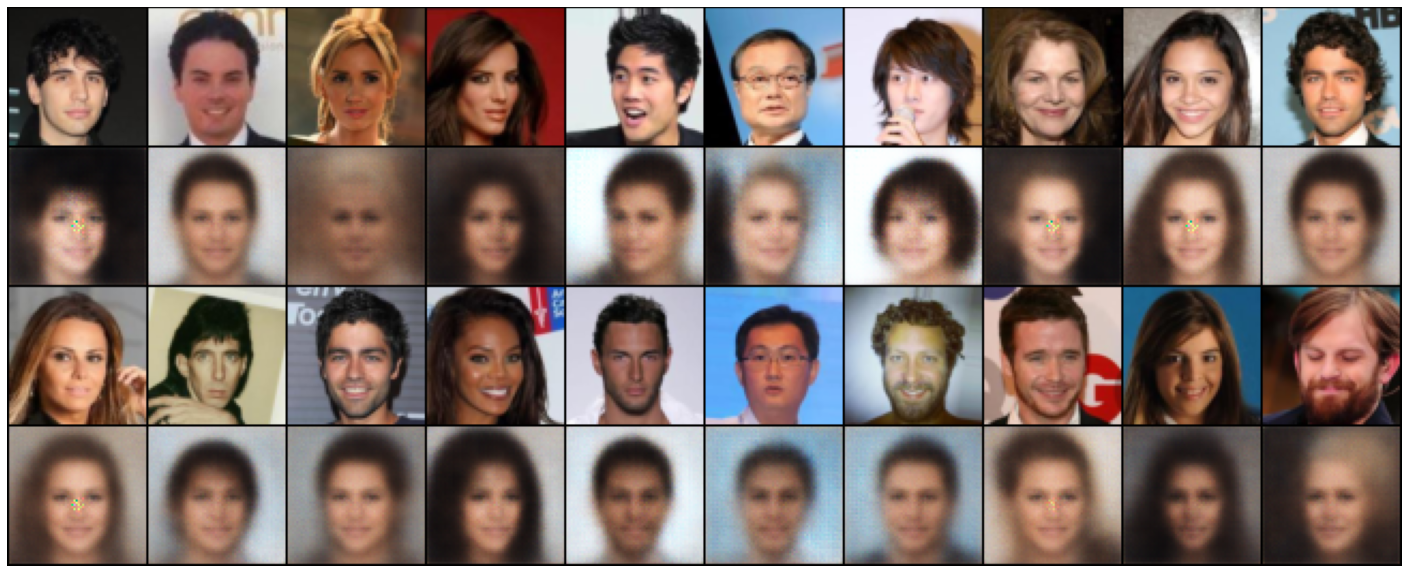

time: 10:28:34        epoch: 001/005        batch: 00791/00792        loss: 0.0714        
time: 10:29:35        epoch: 002/005        batch: 00791/00792        loss: 0.0618        
time: 10:30:35        epoch: 003/005        batch: 00791/00792        loss: 0.0541        
time: 10:31:36        epoch: 004/005        batch: 00791/00792        loss: 0.0559        
time: 10:32:36        epoch: 005/005        batch: 00791/00792        loss: 0.0578        
n_code_dim                               32
n_channels                               3
relu_slope                               0.01
bias                                     False
n_encoder_feature_maps                   32
encoder_feature_map_multiplier           2
n_encoder_dense_layers                   0
encoder_dense_neurons_multiplier         4
encoder_dropout                          0.0
input_noise_p                            0.0
input_noise_std                          0.0
n_decoder_feature_maps                   32
decoder_featu

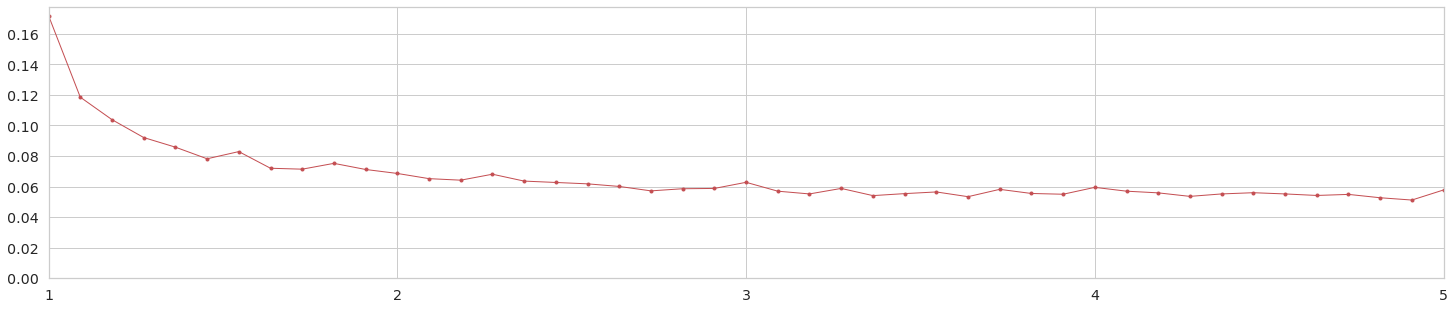

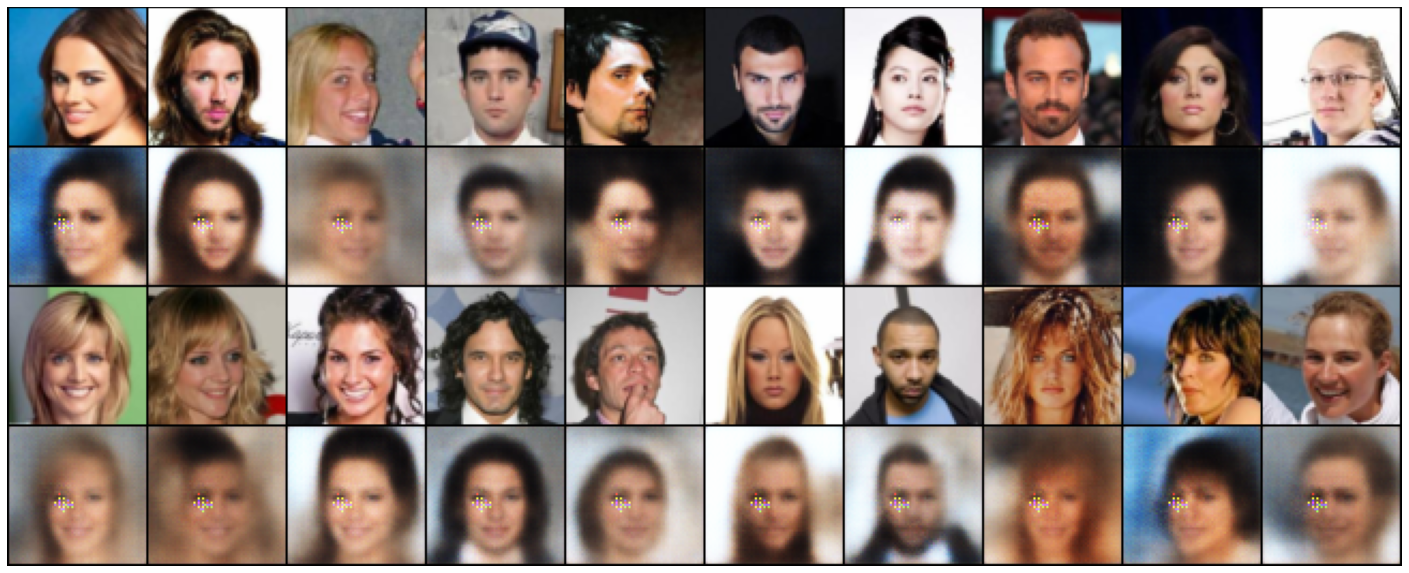

time: 10:33:39        epoch: 001/005        batch: 00791/00792        loss: 0.0692        
time: 10:34:40        epoch: 002/005        batch: 00791/00792        loss: 0.0502        
time: 10:35:41        epoch: 003/005        batch: 00791/00792        loss: 0.0427        
time: 10:36:43        epoch: 004/005        batch: 00791/00792        loss: 0.0360        
time: 10:37:44        epoch: 005/005        batch: 00791/00792        loss: 0.0341        
n_code_dim                               128
n_channels                               3
relu_slope                               0.01
bias                                     False
n_encoder_feature_maps                   32
encoder_feature_map_multiplier           2
n_encoder_dense_layers                   0
encoder_dense_neurons_multiplier         4
encoder_dropout                          0.0
input_noise_p                            0.0
input_noise_std                          0.0
n_decoder_feature_maps                   32
decoder_feat

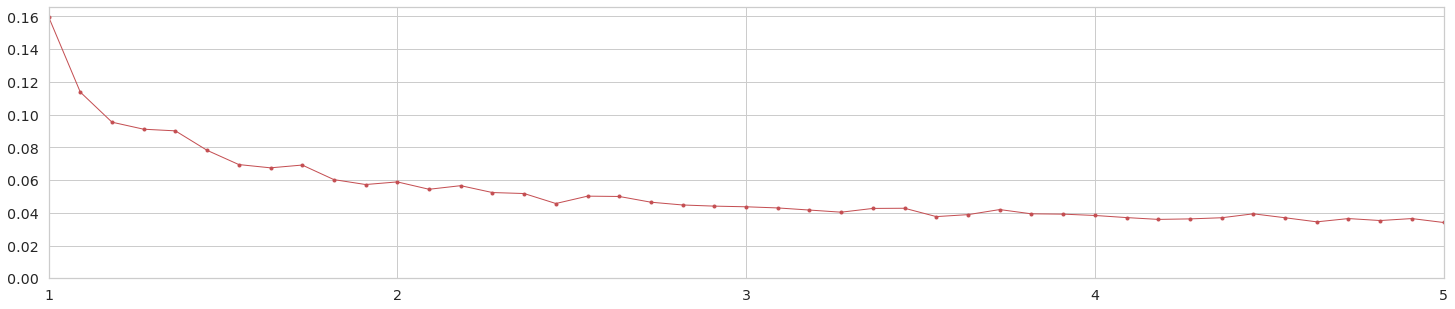

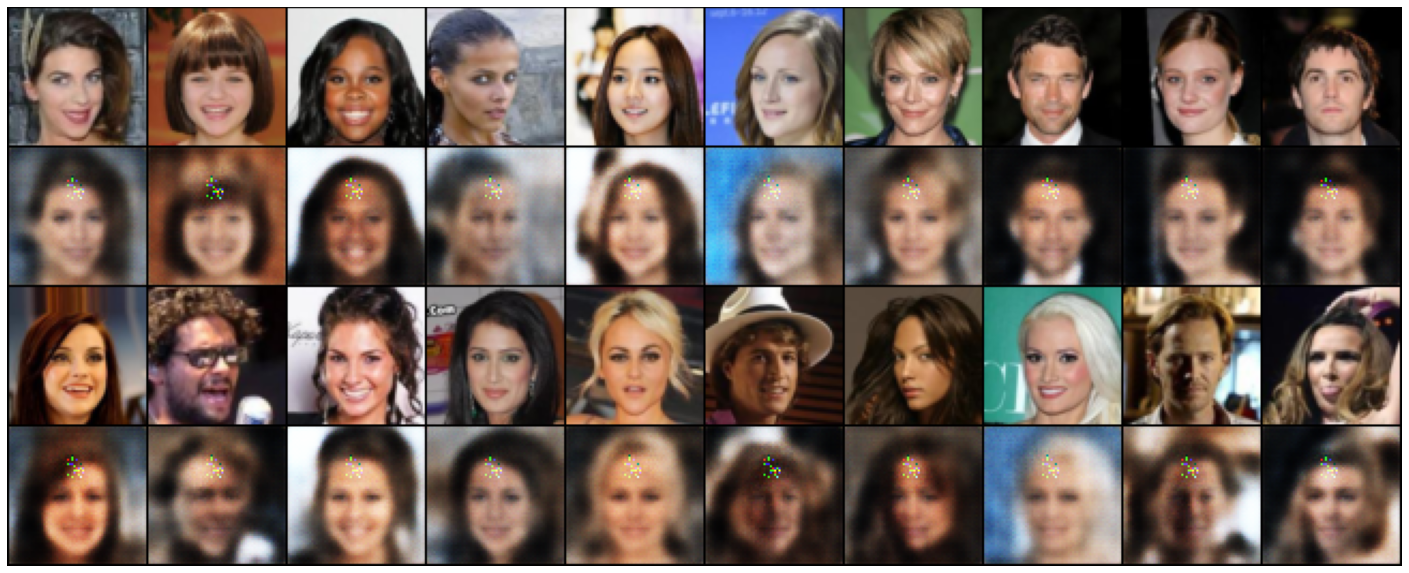

time: 10:38:55        epoch: 001/005        batch: 00791/00792        loss: 0.0525        
time: 10:40:03        epoch: 002/005        batch: 00791/00792        loss: 0.0355        
time: 10:41:12        epoch: 003/005        batch: 00791/00792        loss: 0.0306        
time: 10:42:20        epoch: 004/005        batch: 00791/00792        loss: 0.0294        
time: 10:43:28        epoch: 005/005        batch: 00791/00792        loss: 0.0250        
n_code_dim                               512
n_channels                               3
relu_slope                               0.01
bias                                     False
n_encoder_feature_maps                   32
encoder_feature_map_multiplier           2
n_encoder_dense_layers                   0
encoder_dense_neurons_multiplier         4
encoder_dropout                          0.0
input_noise_p                            0.0
input_noise_std                          0.0
n_decoder_feature_maps                   32
decoder_feat

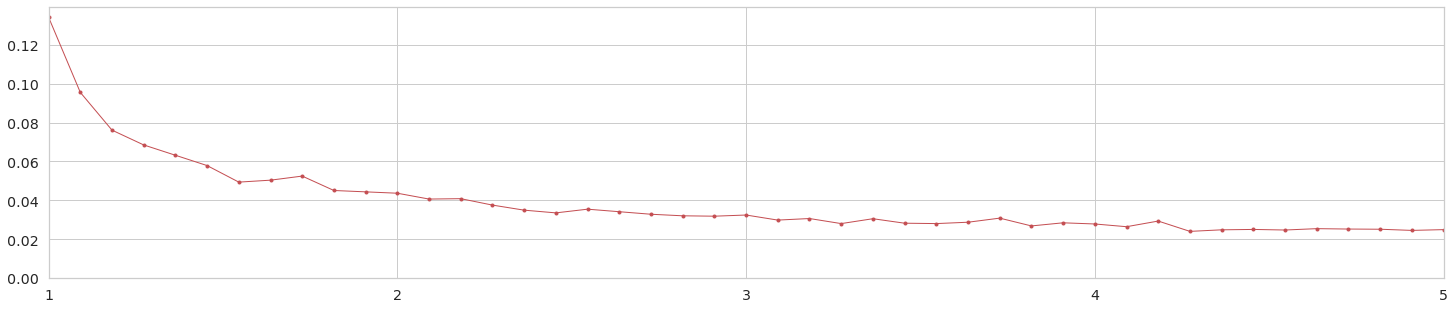

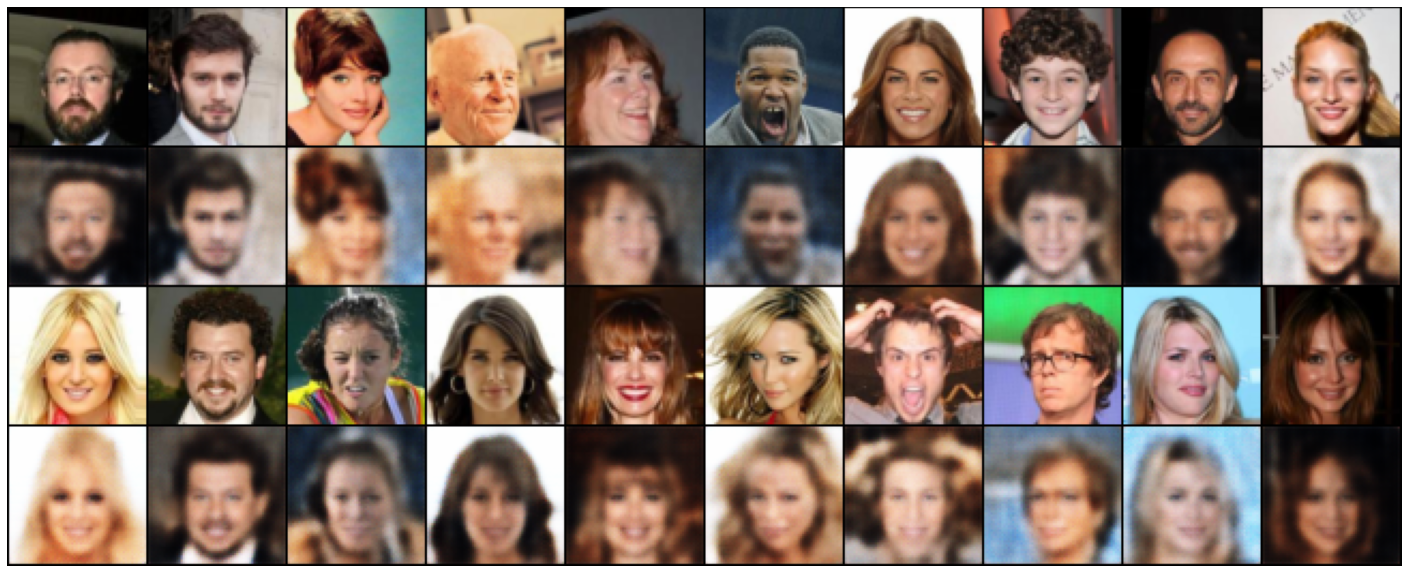

time: 10:45:34        epoch: 001/005        batch: 00791/00792        loss: 0.0448        
time: 10:47:38        epoch: 002/005        batch: 00791/00792        loss: 0.0339        
time: 10:49:42        epoch: 003/005        batch: 00791/00792        loss: 0.0276        
time: 10:51:46        epoch: 004/005        batch: 00791/00792        loss: 0.0249        
time: 10:53:50        epoch: 005/005        batch: 00791/00792        loss: 0.0247        
n_code_dim                               2048
n_channels                               3
relu_slope                               0.01
bias                                     False
n_encoder_feature_maps                   32
encoder_feature_map_multiplier           2
n_encoder_dense_layers                   0
encoder_dense_neurons_multiplier         4
encoder_dropout                          0.0
input_noise_p                            0.0
input_noise_std                          0.0
n_decoder_feature_maps                   32
decoder_fea

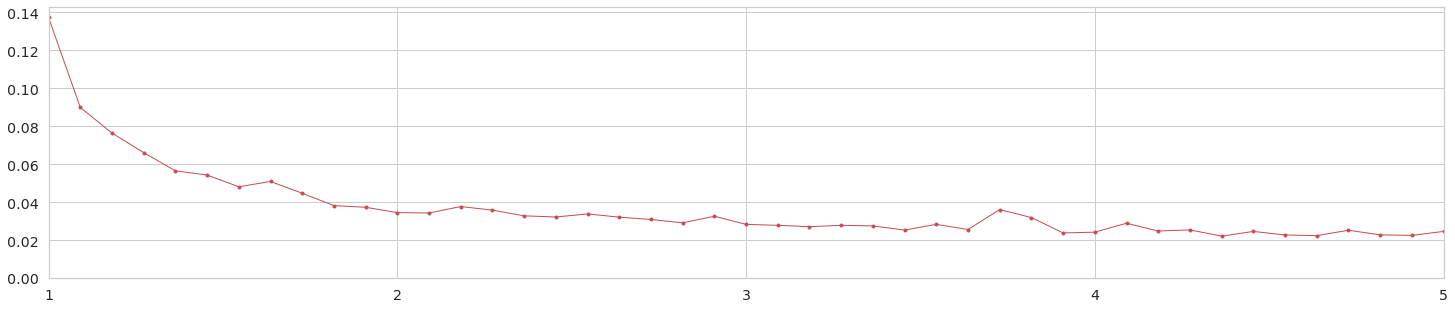

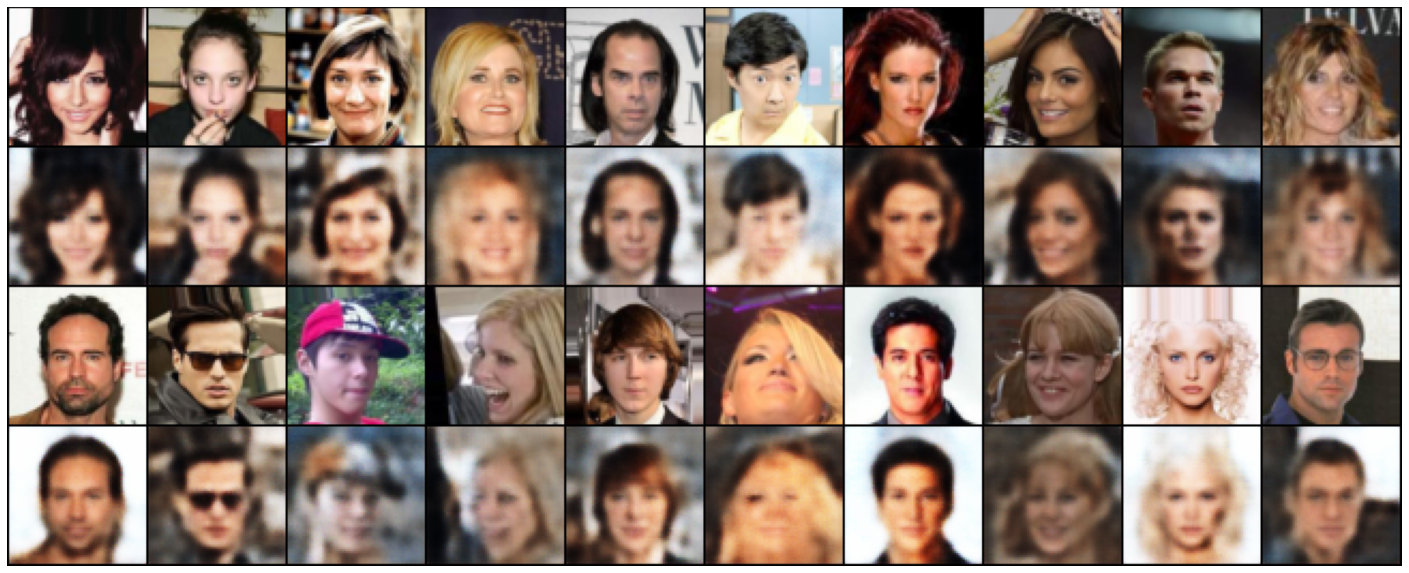

In [5]:
def evaluate_model(model):
    n_epochs = 5
    learning_rate = 1e-4
    weight_decay = 1e-5
    beta1 = 0.5

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(beta1, 0.999))

    losses = []
    start_ts = datetime.datetime.now()
    for epoch in range(1, n_epochs + 1):
        loss = None
        for i, data in enumerate(data_loader, 0):
            optimizer.zero_grad()
            x, _ = data
            x = x.to(device)
            y = model(x)
            l = criterion(x, y)
            l.backward()
            optimizer.step()

            if i in [int(x) for x in np.linspace(0, len(data_loader) - 1, 10)[1:]]:
                losses.append(l)

        print('time: {0}{6}epoch: {1:03d}/{2:03d}{6}batch: {3:05d}/{4:05d}{6}loss: {5:0.4f}{6}'.format(
            datetime.datetime.now().strftime('%H:%M:%S'),
            epoch,
            n_epochs,
            i,
            len(data_loader),
            l,
            '        '))
    
    losses = [round(l.data.item(), 4) for l in losses]
    recent_loss = round(np.mean(losses[-5:]), 4)
    training_time = int((datetime.datetime.now() - start_ts).total_seconds())

    results = model.get_hyperparams()
    results['losses'] = losses
    results['recent_loss'] = recent_loss
    results['training_time'] = training_time
    
    for k in results.keys():
        print(f'{k:40}', results[k])
    
    plt.figure(figsize=(25, 5))
    x_scale = np.linspace(1, n_epochs, len(losses))
    plt.plot(x_scale,
             losses,
             c='r',
             linewidth=1,
             marker='.')
    plt.xticks(range(0, n_epochs + 1))
    plt.xlim(1, n_epochs)
    plt.ylim(0, None)
    plt.show()

    x, _ = next(iter(data_loader))
    x = x.to(device)
    y = model(x)
    plt.figure(figsize=(25,25))
    plt.imshow(np.transpose(torchvision.utils.make_grid(torch.cat((x[:10].detach(),
                                                                   y[:10].detach(),
                                                                   x[10:20].detach(),
                                                                   y[10:20].detach(),), 0),
                                                        nrow=10,
                                                        padding=1,
                                                        normalize=True).cpu(),(1,2,0)))
    plt.axis('off')
    plt.show()
    
    return results

for n_code_dim in [8, 32, 128, 512, 2048]:
    model = AutoEncoder(n_code_dim=n_code_dim,
                        n_encoder_feature_maps=32,
                        n_decoder_feature_maps=32,
                        encoder_feature_map_multiplier=2,
                        decoder_feature_map_multiplier=2,
                        n_decoder_dense_layers=0,
                        n_encoder_dense_layers=0,
                        encoder_dense_neurons_multiplier=4,
                        decoder_dense_neurons_multiplier=4
    ).to(device)
    evaluate_model(model)